# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
import geopandas
import pylab as pl
import collections 
import geopandas as gp
from fiona.crs import from_epsg
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster, linkage

In [2]:
#these commands can be run on the shell and get the data with the command wget
#the cell needs to be run only once
!for ((y=93; y<=99; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

!for ((y=0; y<=1; y+=1)); do wget \
ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done
#2002-2009 data
!for ((y=2; y<=9; y+=1)); do wget \
ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done
#2010-2014 data
!for ((y=10; y<=14; y+=1)); do wget \
ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

--2017-12-08 23:12:36--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
           => “zbp93totals.zip”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2017-12-08 23:17:39--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp93totals.zip
  (try: 2) => “zbp93totals.zip”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp93totals.zip ... done.
==> PASV ... done.    ==> RETR zbp93totals.zip ... 
No such file “zbp93totals.zip”.

--2017-12-08 23:17:39--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp94totals.zip
           => “zbp94totals.zip.2”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:100

Logging in as anonymous ... 
Error in server response, closing control connection.
Retrying.

--2017-12-09 00:08:26--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp01totals.zip
  (try: 2) => “zbp01totals.zip.1”
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp01totals.zip ... 628815
==> PASV ... done.    ==> RETR zbp01totals.zip ... done.
Length: 628815 (614K) (unauthoritative)

100%[======================================>] 628,815      547K/s   in 1.1s    

2017-12-09 00:08:28 (547 KB/s) - “zbp01totals.zip.1” saved [628815]

--2017-12-09 00:08:28--  ftp://ftp.census.gov/econ2002/CBP_CSV/zbp02totals.zip
           => “zbp02totals.zip.2”
Resolving ftp.census.gov... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov|148.129.75.35|:21... connected.
Logging in as anonymous ... 
Err

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


In [2]:
path = os.getenv('PUIDATA')
os.chdir(path)

In [5]:
!curl -O https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   194    0   194    0     0    194      0 --:--:-- --:--:-- --:--:--  1108


In [20]:
zip = zipfile.ZipFile('ZIP_CODE_040114.zip')
zip.extractall()

In [10]:
zipsNYC = gp.GeoDataFrame.from_file('ZIP_CODE_040114.shp')

## You can use zipfile module in python to unzip the files
it should be install in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands, and miss the chance to learn something new)

# Data cleaning

In [3]:
newdf = []
for i in range(94,98):
    a = str(i)
    filename = 'zbp'+ a +'totals.zip'
    zf = zipfile.ZipFile(filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')), index_col=[0], usecols=['zip','est'])
    df.rename(columns={'est':a},inplace=True)
    newdf.append(df)

In [4]:
# due to different column name
for i in range(98,100):
    a = str(i)
    filename = 'zbp'+ a +'totals.zip'
    zf = zipfile.ZipFile(filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')), index_col=[0], usecols=['ZIP','EST'])
    df.rename(columns={'EST':a},inplace=True)
    newdf.append(df)

In [5]:
for i in range(0,3):
    a = str(i)
    filename = 'zbp0'+ a +'totals.zip'
    zf = zipfile.ZipFile(filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')), index_col=[0], usecols=['ZIP','EST'])
    df.rename(columns={'EST':a},inplace=True)
    newdf.append(df)

In [6]:
for i in range(3,15):
    if i < 10:
        a = '0'+ str(i)
    else:
        a = str(i)    
    filename = 'zbp'+ a +'totals.zip'
    zf = zipfile.ZipFile(filename)
    df = pd.read_csv(zf.open(filename.replace('.zip','.txt')), index_col=[0], usecols=['zip','est'])
    df.rename(columns={'est':a},inplace=True)
    newdf.append(df)

In [7]:
Finaldf = newdf[0]
for n in np.arange(len(newdf)-1)+1:
    Finaldf = pd.merge(Finaldf, newdf[n], left_index = True, right_index=True, how = 'inner')

In [8]:
year = range(1994,2015)
Finaldf.columns = year
Finaldf.head(3)

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
1001,439,439,433,457,444,469,493,490,490,505,...,509,509,503,477,458,448,436,453,439,458
1002,450,467,487,500,490,558,563,587,566,586,...,589,582,596,584,571,570,558,572,572,560
1003,10,10,13,15,14,13,13,13,15,16,...,12,12,16,17,16,16,16,15,15,18


In [9]:
Finaldf.shape

(35885, 21)

#### Merge with zipcode data 

In [10]:
Finaldf.reset_index(inplace=True)
Finaldf.head(3)

,index,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,1001,439,439,433,457,444,469,493,490,490,...,509,509,503,477,458,448,436,453,439,458
1,1002,450,467,487,500,490,558,563,587,566,...,589,582,596,584,571,570,558,572,572,560
2,1003,10,10,13,15,14,13,13,13,15,...,12,12,16,17,16,16,16,15,15,18


In [11]:
zipcode = gp.GeoDataFrame.from_file('ZIP_CODE_040114.shp')

In [12]:
zipcode = zipcode[['ZIPCODE','geometry']]
zipcode.ZIPCODE = zipcode.ZIPCODE.astype(int)
zipcode.head(3)

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1..."


In [13]:
data = pd.merge(zipcode, Finaldf,left_on='ZIPCODE', right_on='index',left_index=True,
                right_index = True, how= 'inner')

In [14]:
data.head()

,ZIPCODE,geometry,index,1994,1995,1996,1997,1998,1999,2000,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",1001,439,439,433,457,444,469,493,...,509,509,503,477,458,448,436,453,439,458
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",1002,450,467,487,500,490,558,563,...,589,582,596,584,571,570,558,572,572,560
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",1003,10,10,13,15,14,13,13,...,12,12,16,17,16,16,16,15,15,18
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",1004,47,48,47,41,31,35,48,...,31,30,20,18,18,21,19,16,16,13
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",1005,92,95,101,104,95,82,86,...,94,98,106,97,87,96,91,94,97,97


In [15]:
data.dropna(axis=0,inplace=True)

### standardize
* Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation.
* As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

In [16]:
data.head(1)

,ZIPCODE,geometry,index,1994,1995,1996,1997,1998,1999,2000,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",1001,439,439,433,457,444,469,493,...,509,509,503,477,458,448,436,453,439,458


In [19]:
Tmean = data.iloc[:, range(3,24)].mean(axis = 1)
Tstd = data.iloc[:, range(3,24)].std(axis = 1)
data.iloc[:, range(3,24)] = data.iloc[:, range(3,24)].apply(lambda x : (x - Tmean)/Tstd)


In [20]:
data.head(3)

,ZIPCODE,geometry,index,1994,1995,1996,1997,1998,1999,2000,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",1001,-1.098084,-1.098084,-1.317700,-0.439233,-0.915070,0.000000,0.878467,...,1.464112,1.464112,1.244495,0.292822,-0.402631,-0.768659,-1.207892,-0.585645,-1.098084,-0.402631
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",1002,-2.310615,-1.925513,-1.472451,-1.177961,-1.404492,0.135919,0.249184,...,0.838164,0.679593,0.996736,0.724899,0.430409,0.407756,0.135919,0.453062,0.453062,0.181225
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",1003,-1.995129,-1.995129,-0.598539,0.332521,-0.133009,-0.598539,-0.598539,...,-1.064069,-1.064069,0.798052,1.263582,0.798052,0.798052,0.798052,0.332521,0.332521,1.729112


you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

### The map of the clusters may look something like this

In [26]:
Kdata = data.iloc[:,3:25]
Kdata.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,-1.098084,-1.098084,-1.317700,-0.439233,-0.915070,0.000000,0.878467,0.768659,0.768659,1.317700,...,1.464112,1.464112,1.244495,0.292822,-0.402631,-0.768659,-1.207892,-0.585645,-1.098084,-0.402631
1,-2.310615,-1.925513,-1.472451,-1.177961,-1.404492,0.135919,0.249184,0.792858,0.317143,0.770205,...,0.838164,0.679593,0.996736,0.724899,0.430409,0.407756,0.135919,0.453062,0.453062,0.181225
2,-1.995129,-1.995129,-0.598539,0.332521,-0.133009,-0.598539,-0.598539,-0.598539,0.332521,0.798052,...,-1.064069,-1.064069,0.798052,1.263582,0.798052,0.798052,0.798052,0.332521,0.332521,1.729112
3,1.417467,1.499244,1.417467,0.926806,0.109036,0.436144,1.499244,0.599698,-0.545180,-0.708734,...,0.109036,0.027259,-0.790511,-0.954065,-0.954065,-0.708734,-0.872288,-1.117619,-1.117619,-1.362949
4,-0.457747,0.076291,1.144368,1.678406,0.076291,-2.237875,-1.525824,-0.813773,-0.101722,-0.279734,...,-0.101722,0.610330,2.034432,0.432317,-1.347811,0.254304,-0.635760,-0.101722,0.432317,0.432317


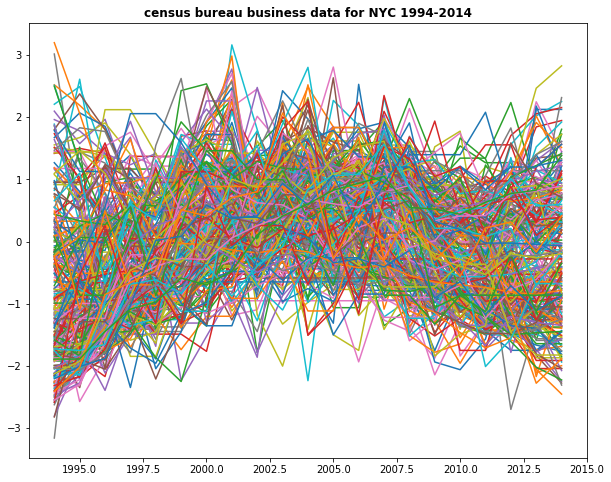

In [27]:
pl.figure(figsize=(10,8))
for i in range(len(Kdata)):
    pl.plot(Kdata.iloc[i])
pl.title('census bureau business data for NYC 1994-2014', weight = 'bold')
pl.show()

### Fig1. census bureau business data for NYC 1994-2014

In [28]:
def get_color(inp, colormap, vmin = None, vmax = None):
    norm = pl.Normalize(vmin, vmax)
    return colormap(norm(inp))

### KMeans

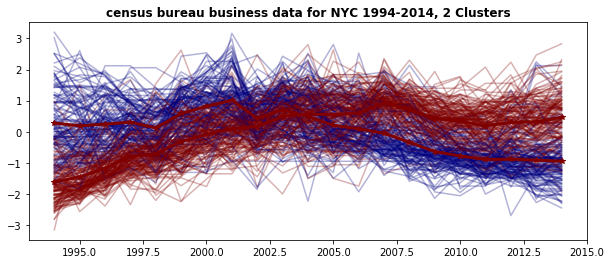

In [29]:
n_clusters = 2
colorsc1 = get_color(np.arange(2),pl.cm.jet)
km = KMeans(n_clusters)
res = km.fit(Kdata)
centers = res.cluster_centers_
labels = res.labels_
pl.figure(figsize = (10,4))
for i in range(len(Kdata)):
    pl.plot(Kdata.iloc[i], c = colorsc1[labels[i]], alpha = 0.3)
# #plot centers
for n in range(n_clusters):
    pl.plot(range(1994,2015), centers[n], '-*', c = colorsc1[labels[n]], linewidth = 3)
pl.title('census bureau business data for NYC 1994-2014, 2 Clusters', weight = 'bold')
pl.show()

### Fig2. census bureau business data for NYC 1994-2014, 2 Clusters

### Plot in a map

In [30]:
data['cluster'] = labels

In [31]:
data.head(2)

,ZIPCODE,geometry,index,1994,1995,1996,1997,1998,1999,2000,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",1001,-1.098084,-1.098084,-1.317700,-0.439233,-0.915070,0.000000,0.878467,...,1.464112,1.244495,0.292822,-0.402631,-0.768659,-1.207892,-0.585645,-1.098084,-0.402631,1
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",1002,-2.310615,-1.925513,-1.472451,-1.177961,-1.404492,0.135919,0.249184,...,0.679593,0.996736,0.724899,0.430409,0.407756,0.135919,0.453062,0.453062,0.181225,1


In [32]:
data['cluster'] = pd.to_numeric(data['cluster'])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


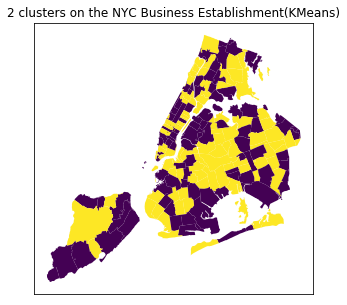

In [33]:
f, ax = pl.subplots(figsize=(5,5))
data.plot(column="cluster", cmap="viridis", figsize=(15,10), ax=ax)
ax.set_title("2 clusters on the NYC Business Establishment(KMeans)")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_bgcolor('white')
pl.show()

### Fig3. NYC Business Establishment Map, 2 Clusters by KMeans.

### Use another clustering algorithm -- Hierarchical

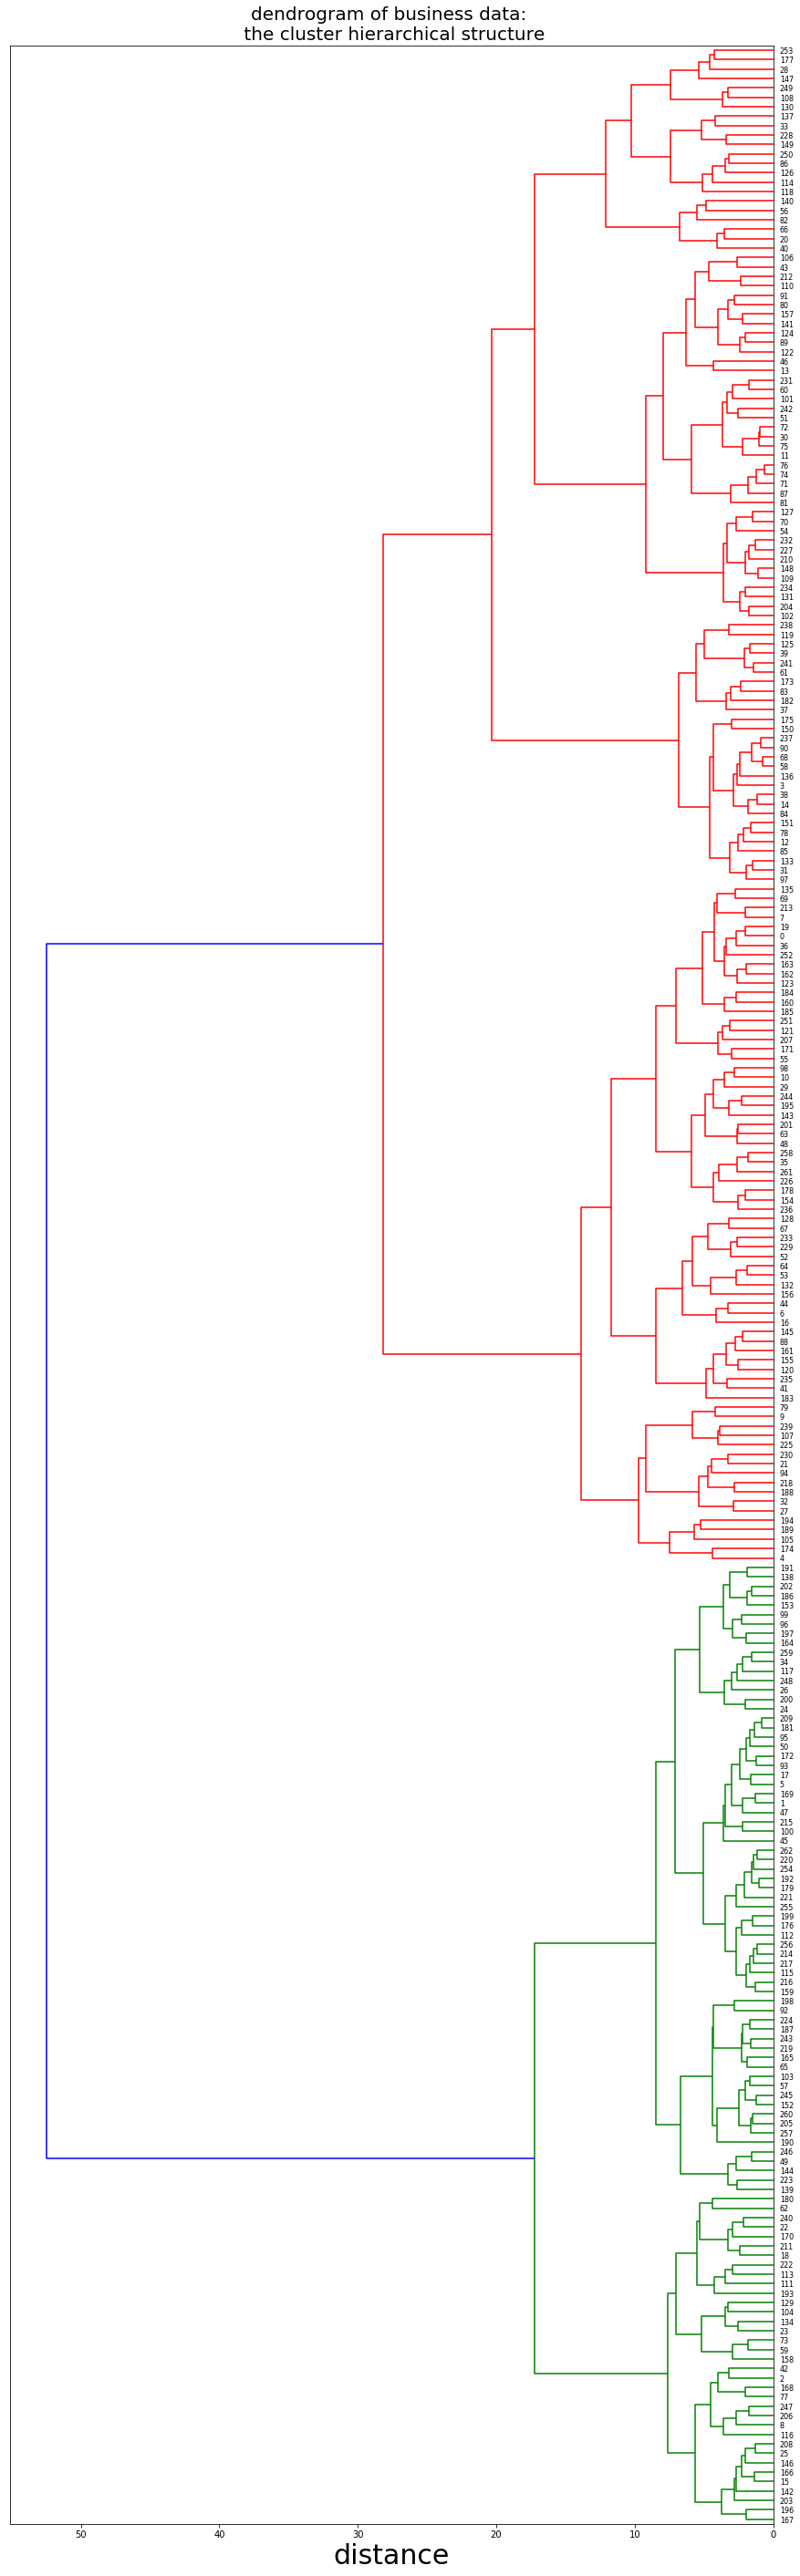

In [34]:
import scipy.cluster as scp
fig = pl.figure(figsize=(15,50))
pl.xlabel("distance", fontsize = 30)
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(Kdata, method='ward'),orientation='left', leaf_font_size=8.)  # font size for the x axis labels
pl.grid('off')
pl.title("dendrogram of business data: \n the cluster hierarchical structure", fontsize=20)
pl.show()

### Fig4. NYC Business Establishment, Clustering by Hierarchical

### KMeans, 3 cluster

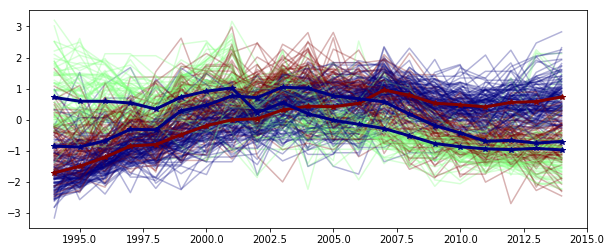

In [35]:
n_clusters = 3
colorsc1 = get_color(np.arange(3),pl.cm.jet)
km = KMeans(n_clusters)
res = km.fit(Kdata)
centers = res.cluster_centers_
labels = res.labels_
pl.figure(figsize = (10,4))
for i in range(len(Kdata)):
    pl.plot(Kdata.iloc[i], c = colorsc1[labels[i]], alpha = 0.3)
# #plot centers
for n in range(n_clusters):
    pl.plot(range(1994,2015), centers[n], '-*', c = colorsc1[labels[n]], linewidth = 3)

pl.show()

### Fig5. NYC Business Establishment, 1994-2014, 3 Clusters(by Kmeans).

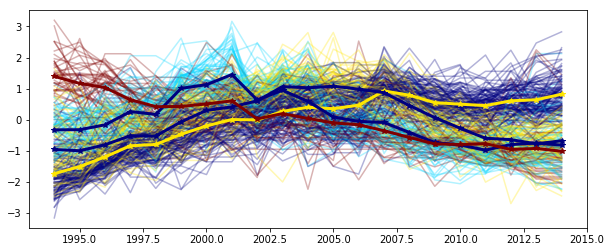

In [36]:
n_clusters = 4
colorsc1 = get_color(np.arange(4),pl.cm.jet)
km = KMeans(n_clusters)
res = km.fit(Kdata)
centers = res.cluster_centers_
labels = res.labels_
pl.figure(figsize = (10,4))
for i in range(len(Kdata)):
    pl.plot(Kdata.iloc[i], c = colorsc1[labels[i]], alpha = 0.3)
# #plot centers
for n in range(n_clusters):
    pl.plot(range(1994,2015), centers[n], '-*', c = colorsc1[labels[n]], linewidth = 3)

pl.show()

### Fig6. NYC Business Establishment, 1994-2014, 4 Clusters(by Kmeans).

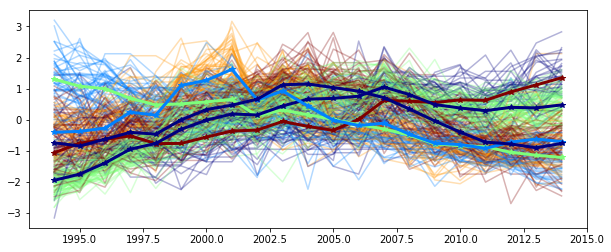

In [37]:
n_clusters = 5
colorsc1 = get_color(np.arange(5),pl.cm.jet)
km = KMeans(n_clusters)
res = km.fit(Kdata)
centers = res.cluster_centers_
labels_5 = res.labels_
pl.figure(figsize = (10,4))
for i in range(len(Kdata)):
    pl.plot(Kdata.iloc[i], c = colorsc1[labels_5[i]], alpha = 0.3)
# #plot centers
for n in range(n_clusters):
    pl.plot(range(1994,2015), centers[n], '-*', c = colorsc1[labels_5[n]], linewidth = 3)

pl.show()

### Fig7. NYC Business Establishment, 1994-2014, 5 Clusters(by Kmeans).

In [113]:
max_d = 17.22
Hcluster = fcluster(linkage(Kdata, method='ward'), max_d, criterion='distance')

In [114]:
data['cluster_5'] = labels_5
data['Hcluster'] = Hcluster

In [115]:
data.Hcluster.unique()

array([2, 1, 3, 4, 5])

In [116]:
data.head(2)

,ZIPCODE,geometry,index,1994,1995,1996,1997,1998,1999,2000,...,2008,2009,2010,2011,2012,2013,2014,cluster,cluster_5,Hcluster
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",1001,-1.098084,-1.098084,-1.317700,-0.439233,-0.915070,0.000000,0.878467,...,0.292822,-0.402631,-0.768659,-1.207892,-0.585645,-1.098084,-0.402631,1,4,2
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",1002,-2.310615,-1.925513,-1.472451,-1.177961,-1.404492,0.135919,0.249184,...,0.724899,0.430409,0.407756,0.135919,0.453062,0.453062,0.181225,1,2,1


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


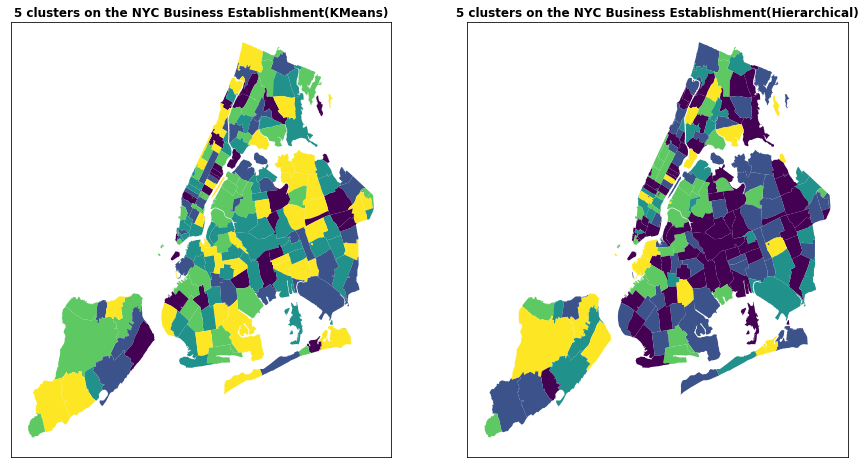

In [123]:
f, (ax1,ax2) = pl.subplots(1, 2,figsize=(15,8))
data.plot(column="cluster_5", cmap="viridis", figsize=(15,10), ax=ax1)
ax1.set_title("5 clusters on the NYC Business Establishment(KMeans)", weight = 'bold')
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_axis_bgcolor('w')
data.plot(column="Hcluster", cmap="viridis", figsize=(15,10), ax=ax2)
ax2.set_title("5 clusters on the NYC Business Establishment(Hierarchical)", weight ='bold')
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_axis_bgcolor('w')
pl.show()

### Fig8. NYC Business Establishment Map, 1994-2014, 5 Clusters.
The left map is clustering by KMeans, the right one is clustering by Hierarchical

## Interpretation

From the two maps above, the cluster distribution is quite similar, and it's easily to understand that lower mahanttan, midtown and downtown brooklyn are within the same cluster since those areas are CBD, and may have similar business establish pattern. The total cluster distribution is sparse may indicate that the difference between zipcode area is significant. 


//anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
//anaconda/lib/python2.7/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


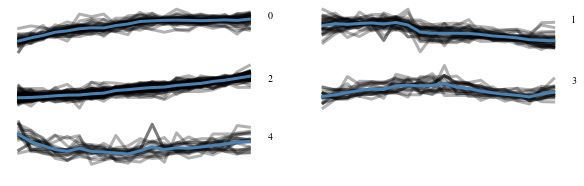

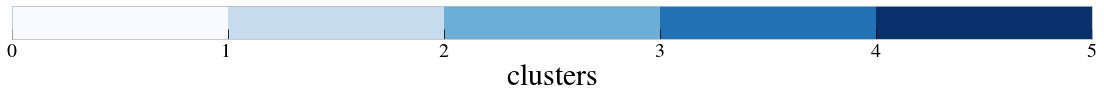

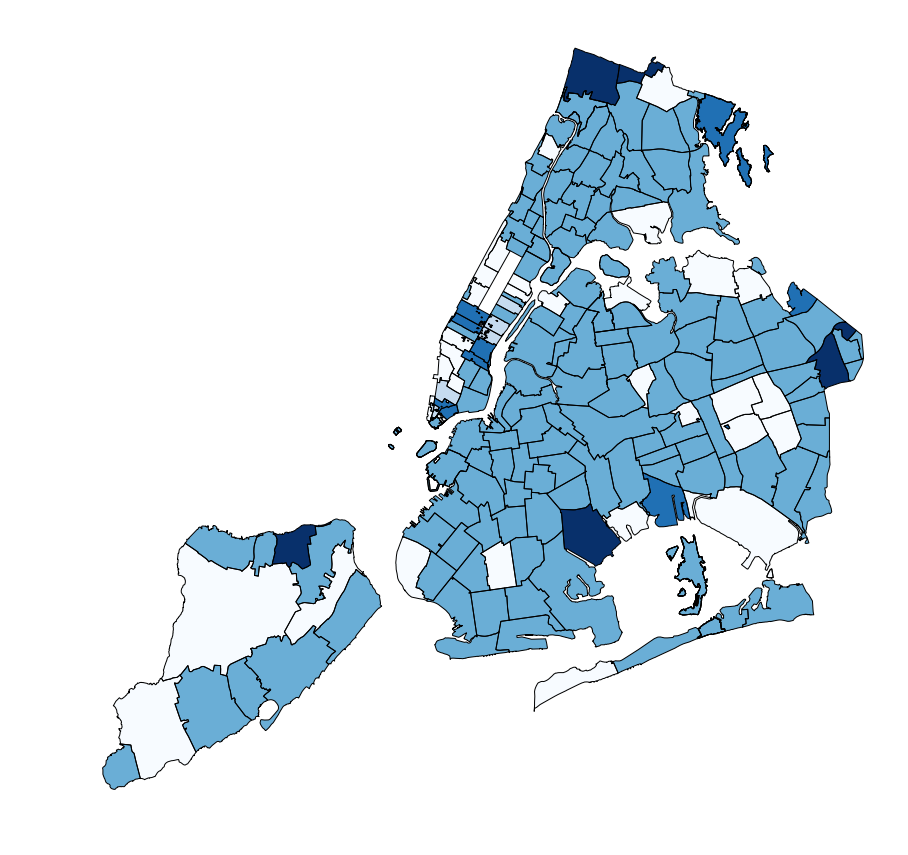

In [16]:
...

### Figure 3: 
cloropleth of  cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

(905410.75604293647,
 1075212.5382562787,
 112386.35181947277,
 280345.45402395504)

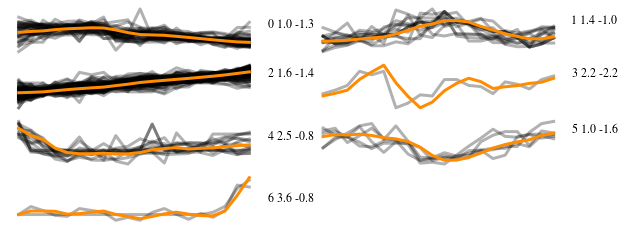

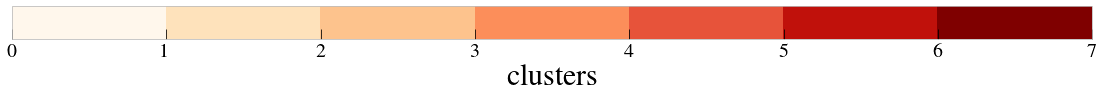

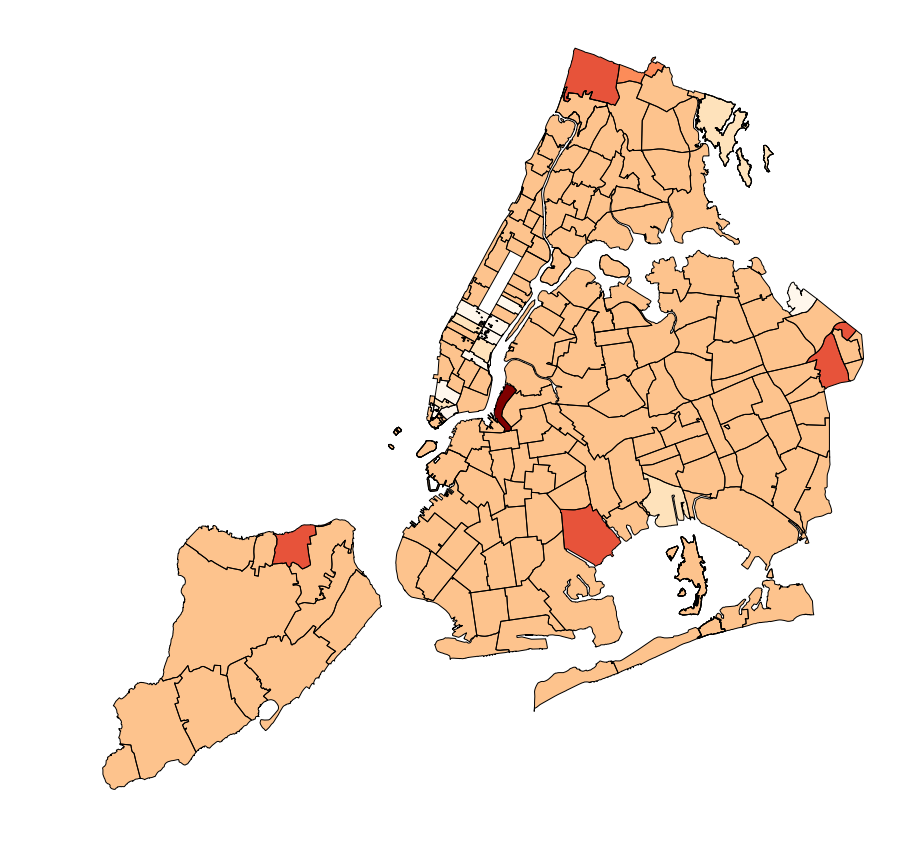

In [29]:
...

### Figure 9: 
As figures 3, 5, 7 for hierarchical agglomerative clustering in 7 clusters, with smoothed time series

### And if you use hierarchical clustering and make a dandrogram it may look like this:

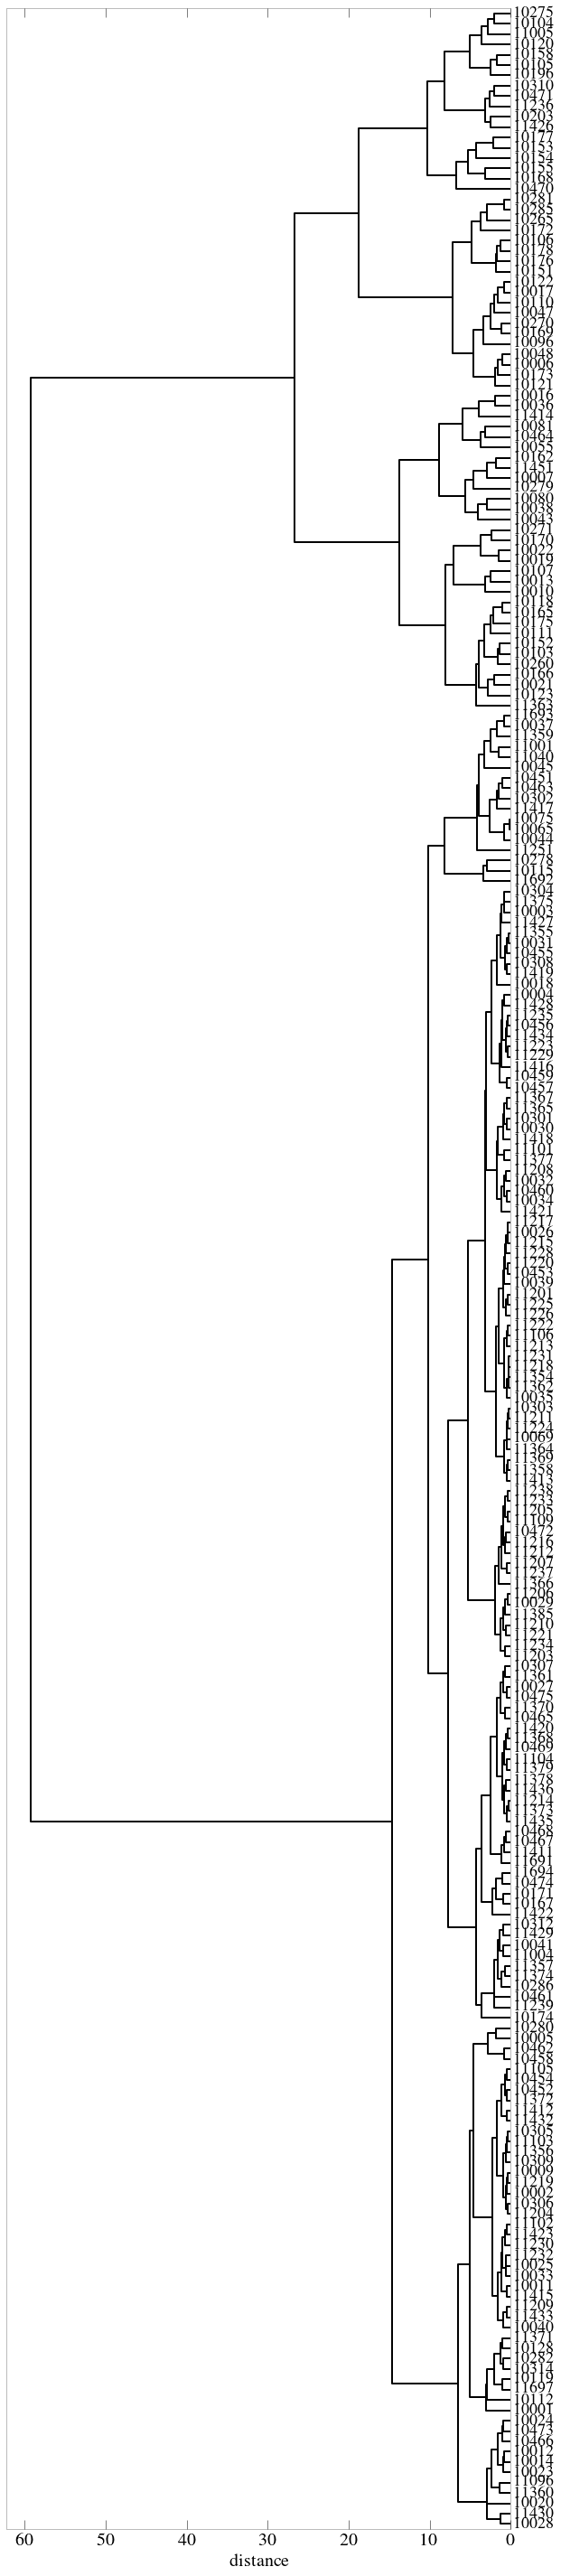

In [1]:
from PIL import Image
Image.open("dandrogram.png")